In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split







In [7]:
# source_dir = "PASS"

# dest_dir_1 = "DATA/PASS"
# dest_dir_2 = "DATA/PASS1"

# os.makedirs(dest_dir_1, exist_ok=True)
# os.makedirs(dest_dir_2, exist_ok=True)

# for filename in os.listdir(source_dir):
#     if filename.endswith("(1).jpeg"):
#         shutil.move(os.path.join(source_dir, filename), os.path.join(dest_dir_1, filename))
#     elif filename.endswith("(2).jpeg"):
#         shutil.move(os.path.join(source_dir, filename), os.path.join(dest_dir_2, filename))

# print("파일 분류 완료!")

In [8]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# original_fail_dir = 'FAIL'
# original_pass_dir = 'PASS'

# base_dir = 'data'
# train_dir = os.path.join(base_dir, 'train')
# test_dir = os.path.join(base_dir, 'test')

# os.makedirs(os.path.join(train_dir, 'FAIL'), exist_ok=True)
# os.makedirs(os.path.join(train_dir, 'PASS'), exist_ok=True)
# os.makedirs(os.path.join(test_dir, 'FAIL'), exist_ok=True)
# os.makedirs(os.path.join(test_dir, 'PASS'), exist_ok=True)

# fail_images = [os.path.join(original_fail_dir, fname) for fname in os.listdir(original_fail_dir) if fname.endswith(('.jpeg', '.png'))]
# pass_images = [os.path.join(original_pass_dir, fname) for fname in os.listdir(original_pass_dir) if fname.endswith(('.jpeg', '.png'))]

# fail_train, fail_test = train_test_split(fail_images, test_size=0.2, random_state=42)
# pass_train, pass_test = train_test_split(pass_images, test_size=0.2, random_state=42)

# def move_files(file_list, target_dir):
#     for file_path in file_list:
#         shutil.move(file_path, target_dir)

# move_files(fail_train, os.path.join(train_dir, 'FAIL'))
# move_files(fail_test, os.path.join(test_dir, 'FAIL'))
# move_files(pass_train, os.path.join(train_dir, 'PASS'))
# move_files(pass_test, os.path.join(test_dir, 'PASS'))

In [3]:
import os
import shutil
import random

image_data_dir = '166_pass_crops'
selected_image_dir = image_data_dir + '_copy'
IMAGE_LIMIT = 100

os.makedirs(selected_image_dir, exist_ok=True)

images = [f for f in os.listdir(image_data_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

random.shuffle(images)

selected_images = images[:IMAGE_LIMIT]

for img in selected_images:
    shutil.copy(os.path.join(image_data_dir, img), os.path.join(selected_image_dir, img))

print(f"{len(selected_images)}개의 이미지를 '{selected_image_dir}'에 무작위로 복사 완료.")

100개의 이미지를 '166_pass_crops_copy'에 무작위로 복사 완료.


In [7]:
def mish(x):
    return x * tf.keras.backend.tanh(tf.keras.backend.softplus(x))

In [ ]:
IMAGE_SIZE = 1024
BATCH_SIZE = 2

image_data_dir = 'DATA'

image_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest',
    brightness_range=[0.2, 1.0]
)

image_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
)

Found 30 images belonging to 1 classes.


In [ ]:
BN_NODE = 1
EPOCHS = 5

def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    noise_input = inputs

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(noise_input)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    bottleneck = layers.Dense(BN_NODE, activation='relu', name="bottleneck")(x)

    encoder = models.Model(inputs, bottleneck, name="encoder")
    return encoder

def build_decoder(bottleneck_dim, original_shape):
    bottleneck_inputs = layers.Input(shape=(bottleneck_dim,))

    x = layers.Dense((original_shape[0] // 8) ** 2 * 256, activation='relu')(bottleneck_inputs)
    x = layers.Reshape((original_shape[0] // 8, original_shape[1] // 8, 256))(x)

    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = layers.UpSampling2D((2, 2))(x)

    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = models.Model(bottleneck_inputs, outputs, name="decoder")
    return decoder

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
encoder = build_encoder(input_shape)
decoder = build_decoder(BN_NODE, input_shape)

inputs = layers.Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = models.Model(inputs, decoded, name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    image_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 1)              │     4,565,121 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1024, 1024, 3)  │     9,349,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,914,372 (53.08 MB)

 Trainable params: 13,914,372 (53.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - loss: 0.1141
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - loss: 0.0524
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - loss: 0.0173
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - loss: 0.0132
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - loss: 0.0121


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


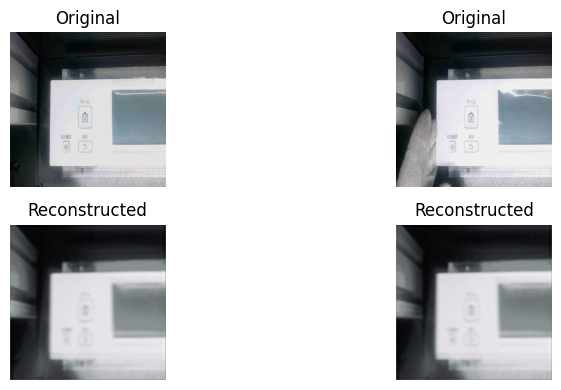

In [ ]:
data_batch, _ = next(image_generator)

predicted_images = autoencoder.predict(data_batch)

def plot_results(original, predicted, n=2):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(predicted[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

original_images = (data_batch * 255).astype(np.uint8)
reconstructed_images = (predicted_images * 255).astype(np.uint8)

plot_results(original_images, reconstructed_images, n=BATCH_SIZE)

In [36]:
print(reconstructed_images.min(), reconstructed_images.max())

3 244


In [ ]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

image1 = 'PASS/EAA100000386(1).jpeg'
image2 = 'FAIL/fail.png'

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

@tf.function
def get_embedding(image_path, encoder_model):
    img_array = preprocess_image(image_path)
    embedding = encoder_model(img_array, training=False)
    return embedding

def calculate_similarity(embedding1, embedding2):
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

embedding1 = get_embedding(image1, encoder)
embedding2 = get_embedding(image2, encoder)

embedding1_np = embedding1.numpy()
embedding2_np = embedding2.numpy()

similarity = calculate_similarity(embedding1_np, embedding2_np)
print(similarity)


Cosine Similarity between the two embeddings: 0.0


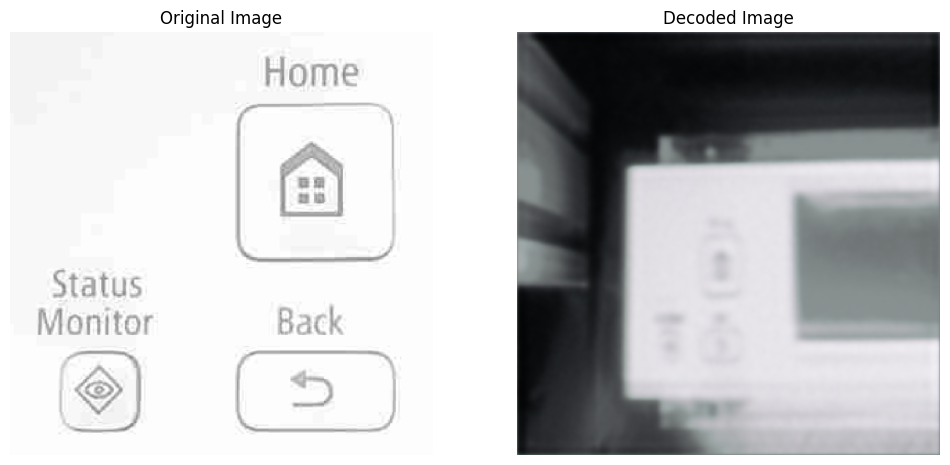

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def load_image(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = img_array / 255.0
    return img_array

def get_encoder_output(encoder, image_path):
    image_data = load_image(image_path)
    image_data = tf.expand_dims(image_data, axis=0)
    return encoder(image_data)

def get_decoder_output(decoder, encoded_image):
    return decoder(encoded_image)

image_path = 'FAIL/fail.png'

encoded_image = get_encoder_output(encoder, image_path)
decoded_image = get_decoder_output(decoder, encoded_image)

decoded_image = decoded_image.numpy().squeeze()

original_image = load_image(image_path)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(decoded_image)
plt.title("Decoded Image")
plt.axis("off")

plt.show()